In [1]:
!pip install emoji -q
!pip install pymorphy2 -q
!python -m spacy download ru_core_news_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [2]:
import copy
from collections import defaultdict
import pathlib

import pandas as pd
import numpy as np
import torch
from torch import nn
import transformers
# from datasets import load_dataset, Features, Value, ClassLabel, LargeList, Sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import emoji
from nltk.stem import SnowballStemmer
import pymorphy2
import spacy

In [3]:
# BACKBONE_NAME = 'cointegrated/rubert-tiny2'
BACKBONE_NAME = "DeepPavlov/rubert-base-cased"
# SUBMISSION_NAME = "rubert_tiny_classifier"
SUBMISSION_NAME = "rubert_base_cased"
NUM_LABELS = 50
BATCH_SIZE = 16
MAX_LEN = 256
RANDOM_STATE = 42
EPOCHS = 100
ROOT_DIR = pathlib.Path().absolute()

stemmer = SnowballStemmer(language="russian")
parser = spacy.load(
    'ru_core_news_sm',
    disable=["parser", "ner"],
)
tqdm.pandas()

In [4]:
ROOT_DIR

PosixPath('/kaggle/working')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
df = pd.read_csv('/kaggle/input/train-da/train_augmented_2.csv')
df_test = pd.read_csv('/kaggle/input/train-da/test.csv')

df_test['text'] = df_test['text'].progress_apply(
    lambda x: emoji.demojize(str(x), language='ru').replace(':', ' ').replace('_', ' ')
)

  0%|          | 0/9015 [00:00<?, ?it/s]

In [7]:
df['text'] = df['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))

  0%|          | 0/7297 [00:00<?, ?it/s]

In [8]:
df_test['text'] = df_test['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))

  0%|          | 0/9015 [00:00<?, ?it/s]

In [17]:
df_test['text'].apply(lambda x: len(tokenizer.tokenize(x))).sort_values()

7219     1
3741     1
3655     1
3667     1
3620     1
        ..
3124    76
5675    77
5277    79
4430    87
8410    96
Name: text, Length: 9015, dtype: int64

In [29]:
df['text'].apply(lambda x: len(tokenizer.tokenize(x))).sort_values(ascending=False).head(20)

7265    2040
6697    1023
7090    1018
7038    1016
7115    1009
6680     820
6674     819
7138     767
6686     685
6692     684
7220     682
7286     439
7242     384
7172     342
4855     105
4880     102
4887     100
4863      98
4846      98
484       92
Name: text, dtype: int64

In [35]:
df['text'][4880]

"постоянство в последний время , несмотря на ... client - ti . внимание . не размещать карта с земля в общий пакет и прод . не реагировать . cl - you purify prod from the ground . everyone doesn't care about complaints , шаблон сообщение . vtusville быть счастливый прод . точно так же , достаточно высокий цена , клиент - т на высота : очень лёгкий оттенок под больший палец : : очень лёгкий оттенок кожа : : тяжёлый оттенок под больший палец : :"

In [36]:
df_train, df_valid = train_test_split(df, random_state=RANDOM_STATE, test_size=0.2, shuffle=True)

In [37]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list=None):
        self.tokenizer = tokenizer
        self.df = df.copy()
        self.text = df['text'].tolist()
        # self.text = df[['assessment', 'tags', 'text']].apply(lambda x: f"assessment: {x[0]}, tags: {x[1]}, text: {x[2]}", axis=1).tolist()
        # self.text = df[['tags', 'text']].apply(lambda x: f"tags: {x[0]}, text: {x[1]}", axis=1).tolist()
        self.targets = self.df[target_list].values if target_list else None
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        inputs = self.tokenizer.encode_plus(
            self.text[index],
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) if self.targets is not None else torch.FloatTensor([]),
            'text': self.text[index]
        }

In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained(BACKBONE_NAME)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
' '.join([
    # (print(token), stemmer.stem(token.))[1]
    token.lemma_
    for token in parser('Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов')
])

In [38]:
full_dataset = CustomDataset(df, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
val_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [14]:
next(iter(full_dataset))

{'input_ids': tensor([  101, 33308,  6861, 33412,   128,  7457, 67825,  1655, 70407,  8980,
           128,   625,  2306, 29885,  1655,  4752, 35592,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [39]:
full_data_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

valid_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [40]:
class ClassificationModel(nn.Module):
    def __init__(self, base_transformer_model):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model, return_dict=True)
        clf_in_features = self.backbone.pooler.dense.out_features
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(clf_in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.backbone(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [24]:
model = ClassificationModel(BACKBONE_NAME)

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.backbone.parameters():
#     param.requires_grad = False
model = nn.DataParallel(model)
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): ClassificationModel(
    (backbone): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [25]:
criterion = torch.nn.BCEWithLogitsLoss()

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [50]:
def train(training_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    for batch in training_loader:
        # forward
        outputs = model(
            batch['input_ids'].to(device),
            batch['attention_mask'].to(device),
            batch['token_type_ids'].to(device)
        )
        loss = criterion(outputs, batch['targets'].to(device))
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = batch['targets'].cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return float(correct_predictions)/num_samples, np.mean(losses)

In [51]:
def evaluation(validation_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch in validation_loader:
            outputs = model(
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['token_type_ids'].to(device)
            )

            loss = criterion(outputs, batch['targets'].to(device))
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = batch['targets'].cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(train_data_loader, model, optimizer, criterion)
    val_acc, val_loss = evaluation(valid_data_loader, model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': model.state_dict()},
            f'gdrive/My Drive/ecom_tech_dls/{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

In [ ]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

In [ ]:
trained_model = ClassificationModel(BACKBONE_NAME)

checkpoint = torch.load(f'gdrive/My Drive/ecom_tech_dls/{SUBMISSION_NAME}.pt', map_location=device)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

trained_model.eval()

In [56]:
def write_submission(pred_test, test_df, name):
    answer = []
    np.apply_along_axis(
        lambda x: answer.append(' '.join(np.where(x == 1)[0].astype(str))),
        axis=1,
        arr=pred_test
    )
    test_df[["index"]].assign(target = answer).to_csv(ROOT_DIR / name, index=False)

In [ ]:
preds = None
for batch in tqdm(test_data_loader):
    out = trained_model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    if preds is not None:
        preds = np.append(preds, torch.sigmoid(out).cpu().detach().numpy().round(), axis=0)
    else:
        preds = torch.sigmoid(out).cpu().detach().numpy().round()

In [ ]:
write_submission(preds, df_test, f'{SUBMISSION_NAME}_submission_3.csv')

In [ ]:
res = pd.read_csv(f'{SUBMISSION_NAME}_submission.csv')

In [ ]:
res

In [ ]:
res[~res['target'].isna()]

In [ ]:
SUBMISSION_NAME

In [ ]:
torch.save(
    {'model_state_dict': model.state_dict()},
    ROOT_DIR / f'{SUBMISSION_NAME}.pt',
)

In [27]:
history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(1, EPOCHS+1)):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(full_data_loader, model, optimizer, criterion)
    val_acc, val_loss = evaluation(valid_data_loader, model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': model.state_dict()},
            ROOT_DIR / f'{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


train_loss=0.2325, val_loss=0.1414, train_acc=0.9579, val_acc=0.9662
Saving best model...
Epoch 2/100
train_loss=0.1355, val_loss=0.1309, train_acc=0.9668, val_acc=0.9662
Epoch 3/100
train_loss=0.1235, val_loss=0.1161, train_acc=0.9677, val_acc=0.9684
Saving best model...
Epoch 4/100
train_loss=0.1100, val_loss=0.1020, train_acc=0.9696, val_acc=0.9715
Saving best model...
Epoch 5/100
train_loss=0.0968, val_loss=0.0884, train_acc=0.9720, val_acc=0.9740
Saving best model...
Epoch 6/100
train_loss=0.0847, val_loss=0.0758, train_acc=0.9754, val_acc=0.9779
Saving best model...
Epoch 7/100
train_loss=0.0736, val_loss=0.0646, train_acc=0.9784, val_acc=0.9827
Saving best model...
Epoch 8/100
train_loss=0.0634, val_loss=0.0555, train_acc=0.9821, val_acc=0.9855
Saving best model...
Epoch 9/100
train_loss=0.0548, val_loss=0.0481, train_acc=0.9850, val_acc=0.9890
Saving best model...
Epoch 10/100
train_loss=0.0476, val_loss=0.0412, train_acc=0.9874, val_acc=0.9903
Saving best model...
Epoch 11/100

KeyboardInterrupt: 

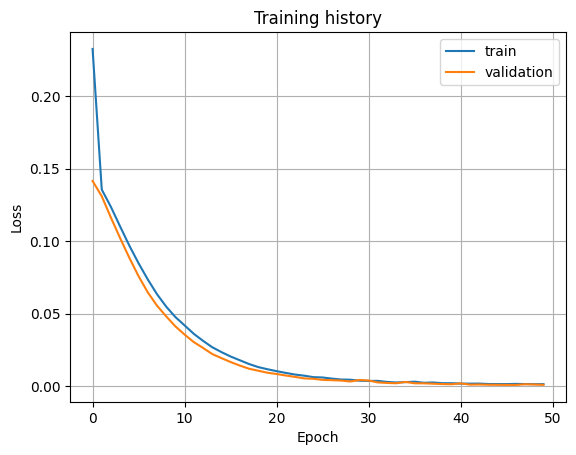

In [28]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

In [29]:
# trained_model = ClassificationModel(BACKBONE_NAME)

# checkpoint = torch.load(ROOT_DIR / f'{SUBMISSION_NAME}.pt', map_location=device)
# trained_model.load_state_dict(checkpoint['model_state_dict'])
# trained_model.to(device)

# trained_model.eval()

model.eval()

preds = None
for batch in tqdm(test_data_loader):
    out = model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    if preds is not None:
        preds = np.append(preds, torch.sigmoid(out).cpu().detach().numpy().round(), axis=0)
    else:
        preds = torch.sigmoid(out).cpu().detach().numpy().round()

write_submission(preds, df_test, f'full_{SUBMISSION_NAME}_submission_2.csv')

  0%|          | 0/564 [00:00<?, ?it/s]

In [30]:
torch.save(
    {'model_state_dict': model.state_dict()},
    ROOT_DIR / f'full_{SUBMISSION_NAME}.pt',
)

In [41]:
SUBMISSION_NAME

'rubert_base_cased'

In [47]:
import kagglehub

In [48]:
kagglehub.model_download('dvkulemin/full_rubert/PyTorch/default/1', path='full_rubert_base_cased.pt')

'/kaggle/input/full_rubert/pytorch/default/1/full_rubert_base_cased.pt'

In [49]:
trained_model = ClassificationModel(BACKBONE_NAME)
trained_model = nn.DataParallel(trained_model)
checkpoint = torch.load('/kaggle/input/full_rubert/pytorch/default/1/full_rubert_base_cased.pt', map_location=device)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_30/762614316.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the curre

DataParallel(
  (module): ClassificationModel(
    (backbone): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [52]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(trained_model.parameters(), lr=1e-5)

In [54]:
history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(1, EPOCHS+1)):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(full_data_loader, trained_model, optimizer, criterion)
    val_acc, val_loss = evaluation(valid_data_loader, trained_model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': trained_model.state_dict()},
            ROOT_DIR / f'{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
train_loss=0.0011, val_loss=0.0006, train_acc=0.9998, val_acc=0.9999
Saving best model...
Epoch 2/100
train_loss=0.0012, val_loss=0.0007, train_acc=0.9998, val_acc=0.9999
Saving best model...
Epoch 3/100
train_loss=0.0009, val_loss=0.0005, train_acc=0.9999, val_acc=1.0000
Saving best model...
Epoch 4/100
train_loss=0.0008, val_loss=0.0007, train_acc=0.9999, val_acc=0.9999
Epoch 5/100
train_loss=0.0013, val_loss=0.0006, train_acc=0.9997, val_acc=0.9999
Epoch 6/100
train_loss=0.0009, val_loss=0.0005, train_acc=0.9999, val_acc=1.0000
Epoch 7/100
train_loss=0.0007, val_loss=0.0004, train_acc=0.9999, val_acc=1.0000
Saving best model...
Epoch 8/100
train_loss=0.0007, val_loss=0.0005, train_acc=0.9999, val_acc=0.9999
Epoch 9/100
train_loss=0.0015, val_loss=0.0006, train_acc=0.9997, val_acc=0.9999
Epoch 10/100
train_loss=0.0009, val_loss=0.0004, train_acc=0.9998, val_acc=1.0000
Epoch 11/100
train_loss=0.0008, val_loss=0.0016, train_acc=0.9998, val_acc=0.9997
Epoch 12/100
train_loss

KeyboardInterrupt: 

In [55]:
# trained_model = ClassificationModel(BACKBONE_NAME)

# checkpoint = torch.load(ROOT_DIR / f'{SUBMISSION_NAME}.pt', map_location=device)
# trained_model.load_state_dict(checkpoint['model_state_dict'])
# trained_model.to(device)

# trained_model.eval()

trained_model.eval()

preds = None
for batch in tqdm(test_data_loader):
    out = trained_model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    if preds is not None:
        preds = np.append(preds, torch.sigmoid(out).cpu().detach().numpy().round(), axis=0)
    else:
        preds = torch.sigmoid(out).cpu().detach().numpy().round()

write_submission(preds, df_test, f'last_submission.csv')

  0%|          | 0/564 [00:00<?, ?it/s]

NameError: name 'write_submission' is not defined

In [57]:
write_submission(preds, df_test, f'last_submission.csv')